# Fine tuning Whisper with my voice

In [ ]:
!pip install --upgrade huggingface_hub
from huggingface_hub import login
login()

In [ ]:
!pip install transformers
!pip install ffmpeg-python
!pip install transformers[torch] -U
!pip install accelerate -U
!pip install datasets

In [ ]:
import whisper

model = whisper.load_model("base")

In [ ]:
"""
References:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
!mkdir audio

mkdir: cannot create directory ‘audio’: File exists


In [ ]:
import scipy
import os

sentenceList = []
fileList = []
i = 0
while i<10:
    audio, sr = get_audio()
    scipy.io.wavfile.write(f'./audio/recording{i}.wav', sr, audio)
    while not os.path.exists(f"./audio/recording{i}.wav"):
        time.sleep(0.1)
    sentence = model.transcribe(f'./audio/recording{i}.wav', language="English")['text']
    print(sentence)
    is_correct = input("Is the transcription correct? (y/n)")
    if is_correct == "y":
        fileList.append(f'./audio/recording{i}.wav')
        sentenceList.append(sentence)
    else:
        # Delete the file
        os.remove(f"./audio/recording{i}.wav")
        print("Please try again.")
        i = i - 1
    i+=1


KeyboardInterrupt: 

In [ ]:
# write the sentences to a file
with open("./audio/sentences.txt", "w") as f:
    for sentence in sentenceList:
        f.write(sentence + "\n")

In [ ]:
fileList = ['./audio/recording0.wav', './audio/recording1.wav', './audio/recording2.wav', './audio/recording3.wav', './audio/recording4.wav', './audio/recording5.wav', './audio/recording6.wav', './audio/recording7.wav', './audio/recording8.wav', './audio/recording9.wav']
sentenceList = [' The sun is shining brightly.', ' I like to eat spicy pizza.', ' Dogs bark very loudly.', ' Rain falls from the sky.', ' Birds chirp in the morning.', ' He plays the guitar well.', ' Flowers bloom in the spring.', ' We watch movies together.', ' She reads books often.', ' I like socks.']

In [ ]:
from datasets import DatasetDict, Dataset, Audio
common_voice = DatasetDict()
print(sentenceList)
print(fileList)
# Split in train and test
train_size = int(len(fileList) * 0.8)
test_size = len(fileList) - train_size
common_voice["train"] = Dataset.from_dict({"audio": fileList[:train_size], "sentence": sentenceList[:train_size]}).cast_column("audio", Audio())
common_voice["test"] = Dataset.from_dict({"audio": fileList[train_size:], "sentence": sentenceList[train_size:]}).cast_column("audio", Audio())

[' The sun is shining brightly.', ' I like to eat spicy pizza.', ' Dogs bark very loudly.', ' Rain falls from the sky.', ' Birds chirp in the morning.', ' He plays the guitar well.', ' Flowers bloom in the spring.', ' We watch movies together.', ' She reads books often.', ' I like socks.']
['./audio/recording0.wav', './audio/recording1.wav', './audio/recording2.wav', './audio/recording3.wav', './audio/recording4.wav', './audio/recording5.wav', './audio/recording6.wav', './audio/recording7.wav', './audio/recording8.wav', './audio/recording9.wav']


In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="English", task="transcribe")

In [ ]:
input_str = common_voice["train"][0]["sentence"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                  The sun is shining brightly.
Decoded w/ special:    <|startoftranscript|><|en|><|transcribe|><|notimestamps|> The sun is shining brightly.<|endoftext|>
Decoded w/out special:  The sun is shining brightly.
Are equal:             True


In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="English", task="transcribe")

In [ ]:
print(common_voice["train"][0])

{'audio': {'path': './audio/recording0.wav', 'array': array([ 0.        ,  0.        ,  0.        , ..., -0.0010376 ,
       -0.0010376 , -0.00100708]), 'sampling_rate': 48000}, 'sentence': ' The sun is shining brightly.'}


In [ ]:
# Cast the sampling rate
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))
print(common_voice["train"][0])

{'audio': {'path': './audio/recording0.wav', 'array': array([ 1.27897692e-12, -4.54747351e-13,  9.37916411e-13, ...,
       -1.34542724e-03, -1.14590675e-03, -1.12880487e-03]), 'sampling_rate': 16000}, 'sentence': ' The sun is shining brightly.'}


In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=4)

Map (num_proc=4):   0%|          | 0/8 [00:00<?, ? examples/s]

num_proc must be <= 2. Reducing num_proc to 2 for dataset of size 2.


Map (num_proc=2):   0%|          | 0/2 [00:00<?, ? examples/s]

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
!pip install evaluate
!pip install jiwer

In [ ]:
import evaluate

metric = evaluate.load("wer")

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

In [ ]:
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-custom",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=10, #500
    max_steps=50, #4000
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=10, #1000
    eval_steps=10, #1000
    logging_steps=5,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
    push_to_hub_model_id="whisper-small-custom",
    push_to_hub_dataset_config="mattia-config",
)

TypeError: Seq2SeqTrainingArguments.__init__() got an unexpected keyword argument 'push_to_hub_dataset_config'

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
10,2.141700,3.080751,0.000000
20,0.654400,1.236365,57.142857
30,0.417900,1.054110,57.142857
40,0.362200,0.938256,1000.000000
50,0.333900,0.872634,0.000000


Checkpoint destination directory ./whisper-small-custom/checkpoint-10 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory ./whisper-small-custom/checkpoint-20 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be

TrainOutput(global_step=50, training_loss=0.882443995475769, metrics={'train_runtime': 253.4794, 'train_samples_per_second': 3.156, 'train_steps_per_second': 0.197, 'total_flos': 1.15434160128e+17, 'train_loss': 0.882443995475769, 'epoch': 50.0})

In [ ]:
kwargs = {
    "dataset": "Mattia's Dataset",  # a 'pretty' name for the training dataset
    "dataset_args": "config: en, split: test",
    "language": "en",
    "model_name": "Whisper Small Custom - Mattia Colbertaldo",  # a 'pretty' name for your model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
    "tags": "hf-asr-leaderboard",
}


#trainer.push_to_hub("whisper-small-custom")
trainer.push_to_hub(**kwargs)
tokenizer.push_to_hub("whisper-small-custom")

CommitInfo(commit_url='https://huggingface.co/mattia-colbertaldo/whisper-small-custom/commit/1165375244311ec480e01e5a5cde00c880be85ea', commit_message='Upload tokenizer', commit_description='', oid='1165375244311ec480e01e5a5cde00c880be85ea', pr_url=None, pr_revision=None, pr_num=None)

# Loading the fine tuned model

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Load the model with a pipeline

In [1]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="mattia-colbertaldo/whisper-small-custom")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Load the model directly

In [ ]:
# Load model directly
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq

processor = AutoProcessor.from_pretrained("mattia-colbertaldo/whisper-small-custom")
model = AutoModelForSpeechSeq2Seq.from_pretrained("mattia-colbertaldo/whisper-small-custom")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor

model = WhisperForConditionalGeneration.from_pretrained("mattia-colbertaldo/whisper-small-custom")
processor = WhisperProcessor.from_pretrained("mattia-colbertaldo/whisper-small-custom")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Text to speech function

In [4]:
!pip install numpy scipy librosa unidecode inflect
from scipy.io.wavfile import write
from IPython.display import Audio
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

import torch


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


NameError: name 'torch' is not defined

# UI

In [2]:
!pip install gradio

  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached ffmpy-0.3.1-py3-none-any.whl
     ---------------------------------------- 0.0/50.5 kB ? eta -:--:--
     ---------------------------------------- 50.5/50.5 kB ? eta 0:00:00
     ---------------------------------------- 0.0/65.6 kB ? eta -:--:--
     ---------------------------------------- 65.6/65.6 kB 3.7 MB/s eta 0:00:00
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Using cached python_multipart-0.0.6-py3-none-any.whl (45 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
     ---------------------------------------- 0.0/45.9 kB ? eta -:--:--
     ---------------------------------------- 45.9/45.9 kB ? eta 0:00:00
  Using cached websockets-11.0.3-cp310-cp310-win_amd64.whl (124 kB)
  Using cached toolz-0.12.0-py3-none-any.whl (55 kB)
     ---------------------------------------- 0.0/58.3 kB ? eta -:--:--
     ---------------------------------------- 58.3/58.3 kB ? eta 0:

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires tensorflow-estimator<2.13,>=2.12.0, but you have tensorflow-estimator 2.11.0 which is incompatible.
ydata-profiling 4.2.0 requires pydantic<2,>=1.8.1, but you have pydantic 2.5.3 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="mattia-colbertaldo/whisper-small-custom")

def text_to_speech(text):
    sequences, lengths = utils.prepare_input_sequence([text])
    with torch.no_grad():
        mel, _, _ = tacotron2.infer(sequences, lengths)
        audio = waveglow.infer(mel)
    audio_numpy = audio[0].data.cpu().numpy()
    rate = 22050
    # return sr, audio
    return audio_numpy, rate

def answer(audio):
    text = pipe(audio)["text"]
    
    if text=="":
      text = "Sorry, I didn't understand"
    audio_np, rate = text_to_speech(text)
    
    return text

    # Save the audio to a temporary file
    #temp_audio_file = "./tmp/temp_audio.wav"
    #write(temp_audio_file, rate, audio_np)

    #return temp_audio_file

input_audio = gr.Audio(
    sources=["microphone"],
    waveform_options=gr.WaveformOptions(
        waveform_color="#01C6FF",
        waveform_progress_color="#0066B4",
        skip_length=2,
        show_controls=False,
    ),
)


iface = gr.Interface(
    fn=answer,
    inputs=gr.Audio(source="microphone", type="numpy", label="Speak"),
    outputs="text", #gr.Audio(type="filepath"),
    title="Mattia's Whisper Small",
    description="Realtime demo for Mattia's custom speech recognition using a fine-tuned Whisper small model.",
)

iface.launch()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# Text to Speech


We'll make use of the Tacotron2 system following this notebook: https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/nvidia_deeplearningexamples_tacotron2.ipynb

To run the following code you will need to use a GPU, so change the runtime above to include one if you haven't already.

In [ ]:
!pip install numpy scipy librosa unidecode inflect
#!apt-get update
#!apt-get install -y libsndfile1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00


Load the Tacotron model from Torchhub:

In [ ]:
import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

Tacotron is a "Spectrogram predictor". It has been trained to input a text (or phonetic sequence) and output a mel spectrogram. A Vocoder is then needed to convert the spectrogram into an audio signal. In our case we will make use of the Waveglow vocoder for this purpose: https://github.com/NVIDIA/waveglow

Load the waveglow model as follows:

In [ ]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

Now we have all we need. Let's write some text that we can use to generate the audio:

In [ ]:
text = "Valentina puzza"

That text is read in by the model and converted to a numeric sequence:

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])
sequences

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


tensor([[59, 38, 49, 42, 51, 57, 46, 51, 38, 11, 53, 58, 63, 63, 38, 11, 41, 46,
         11, 40, 38, 40, 40, 38, 11, 50, 52, 49, 49, 42]], device='cuda:0')

### 3.1 Producing a Spectrogram

Now convert the sequence into a mel spectrogram with Tacotron2

In [ ]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)

We now have a spectrogram:

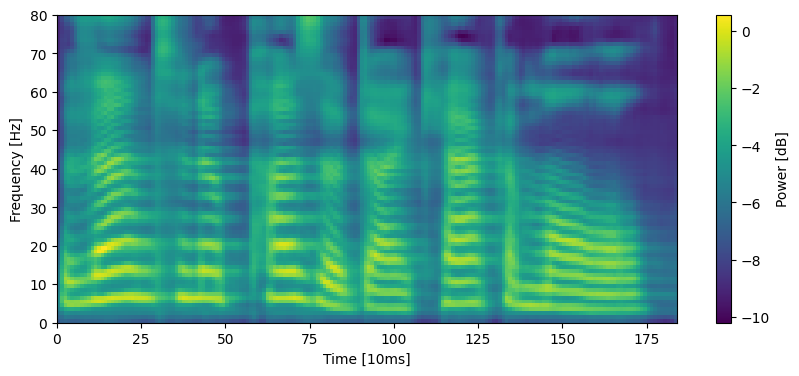

In [ ]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel[0].cpu().numpy())
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [10ms]')
plt.show()

### 3.2 Producing Audio

Now use Waveglow to produce the audio signal

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050
audio_numpy

array([-0.00036586, -0.00062438, -0.00066675, ...,  0.00110832,
        0.00137036,  0.00154507], dtype=float32)

Have a look at the audio signal:

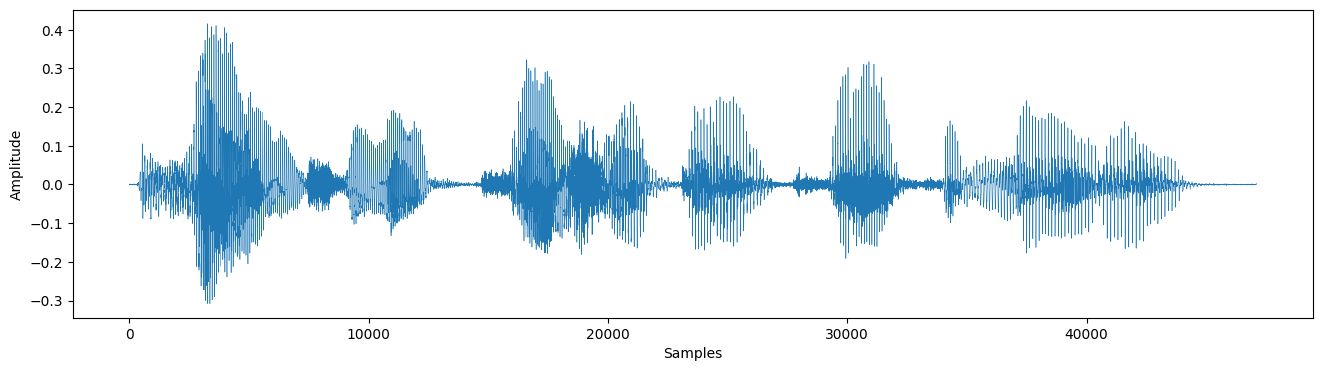

In [ ]:
fig = plt.figure(figsize=(16,4))
plt.plot(audio_numpy, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

Let's listen to it!

In [ ]:
from IPython.display import Audio
Audio(audio_numpy, rate=rate)

Why not save the audio and see if the speech-to-text system can recognise it?

In [ ]:
from scipy.io.wavfile import write
write("audio.wav", rate, audio_numpy)

The END. Hope you liked the Speech tutorial!

In [1]:
!pip install numpy scipy librosa unidecode inflect
from scipy.io.wavfile import write
from IPython.display import Audio
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

def text_to_speech(text):
    sequences, lengths = utils.prepare_input_sequence([text])
    with torch.no_grad():
        mel, _, _ = tacotron2.infer(sequences, lengths)
        audio = waveglow.infer(mel)
    audio_numpy = audio[0].data.cpu().numpy()
    rate = 22050
    return Audio(audio_numpy, rate=rate)

SyntaxError: invalid syntax (3117452129.py, line 1)

# Previous version

## 1.0 Representing Audio Signals
In this section we will investigate audio signals and their various representations. (This part of the tutorial is based on code written by Dr Vincenzo Scotti.)

### 1.4 Record voice

We'll use code to record audio from here: https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb

In [ ]:
!pip install ffmpeg-python
!mkdir ./tmp

In [ ]:
"""
References:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio, sr = get_audio()

In [ ]:
import scipy
scipy.io.wavfile.write('recording.wav', sr, audio)

Copy code from above to generate the Mel Spectrogram for your own voice.

## 2.0 Speech Recognition

Now that we know how to represent audio signals in a way that highlights the different components of the speech, we can try to make use of techniques for recognising speech sounds in the signal.

We will make use of a state-of-the-art transformer-based speech recognition system from OpanAI called Whisper: https://github.com/openai/whisper



Let's first install the Python library:

In [5]:
!pip install -U openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=801356 sha256=e4aecf5d95dfdd085503e02e1a879ebd1fc9ed3fd00cb3b02bbe7ae8591fc130
  Stored in directory: /root/.cache/pip/wheels/d0/85/e1/9361b4cbea7dd4b7f6702fa4c3afc94877952eeb2b62f45f56
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


Whisper models come pretrained with various model sizes. We will download one of the smaller models, called "base", which is only 139MB. Feel free to try a larger model!

In [6]:
import whisper

model = whisper.load_model("base")

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 124MiB/s]


Now that we have the model, we can use it for transcribing audio to text. Let's start with our original WAV file.

In [ ]:
result = model.transcribe("./recording.wav")
print(result["text"])

 Valentina Stiegs.


If you see a warning (about FP16 not being supported) just ignore it. It's because you are running Whisper on the CPU rather than a GPU, but there's no need for a GPU for the moment.

How did it go? Did it transcribe the text correctly?
(If not, why not, and what could be done about it?)

### 2.1 Detecting the spoken language

The model we downloaded for Whisper can transcribe text not only in English but in MANY languages.

As part of the functionality Whisper can detect the spoken language, so let's try it.

We will now follow the pipeline for processing the audio that was hidden from us when we directly called the "transcribe()" method above. The first step is to detect the speech in the audio signal and trim or pad the signal to a certain length (30 seconds):

In [ ]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("./recording.wav")
audio = whisper.pad_or_trim(audio)
audio

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

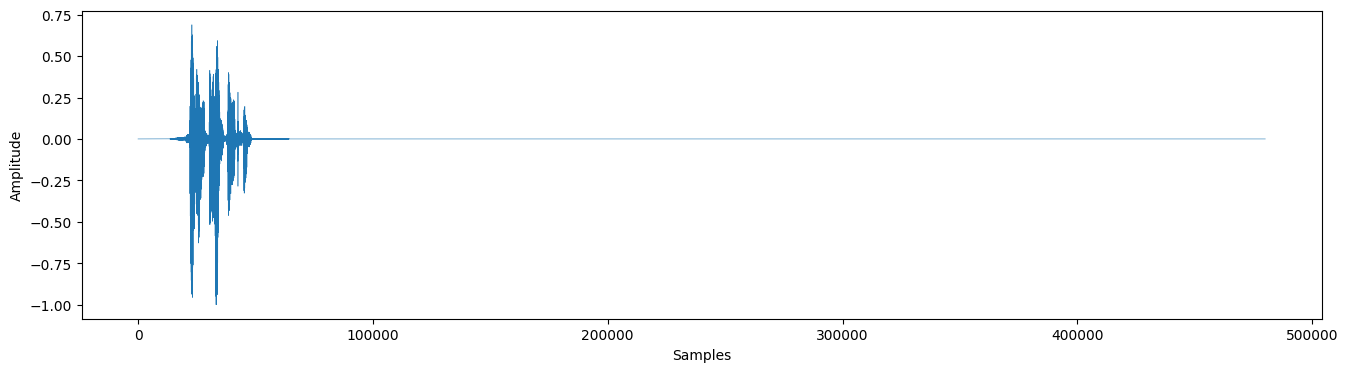

In [ ]:
fig = plt.figure(figsize=(16,4))
plt.plot(audio, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

The next step is to compute the Mel Spectrogram:

In [ ]:
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)
mel

tensor([[-0.6217, -0.6217, -0.6217,  ..., -0.6217, -0.6217, -0.6217],
        [-0.6217, -0.6217, -0.6217,  ..., -0.6217, -0.6217, -0.6217],
        [-0.6217, -0.6217, -0.6217,  ..., -0.6217, -0.6217, -0.6217],
        ...,
        [-0.6217, -0.6217, -0.6217,  ..., -0.6217, -0.6217, -0.6217],
        [-0.6217, -0.6217, -0.6217,  ..., -0.6217, -0.6217, -0.6217],
        [-0.6217, -0.6217, -0.6217,  ..., -0.6217, -0.6217, -0.6217]],
       device='cuda:0')

Let's visualise the spectrogram:

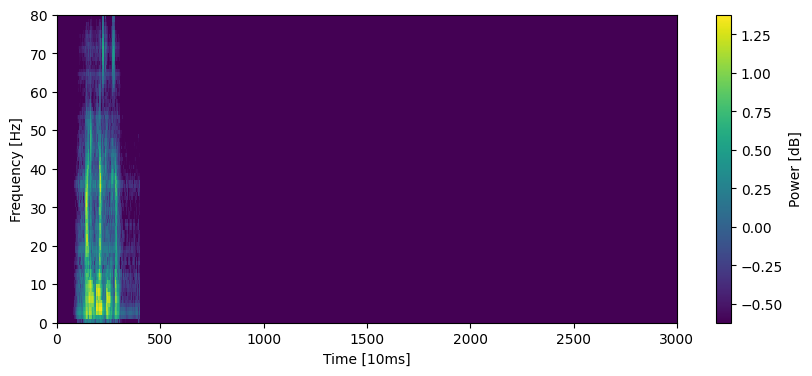

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel.cpu().numpy())
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [10ms]')
plt.show()

Note that the signal has been padded out to 30 seconds.

Now let's use Whisper to detect the language based on the audio clip:

In [ ]:
_, probs = model.detect_language(mel)
lang = max(probs, key=probs.get)
print(f"Detected language: {lang}, confidence: {probs[lang]}")

Detected language: de, confidence: 0.3350006937980652


So the model is pretty certain that the language is English!

Although it had quite a few languages to choose from. Have a look:

In [ ]:
# probs

Try loading the second audio sample from the tutorial "italiano.mp3" and see if the model can correctly determine the language.

In [ ]:
import urllib

# Download wav file from link
link = 'https://drive.switch.ch/index.php/s/MDMM0K7wJaxOJFA/download'

# Use urllib to download the file
urllib.request.urlretrieve(link, './tmp/audio2.mp3')

audio2 = whisper.load_audio("./tmp/audio2.mp3")

Audio(audio2, rate=16000)

In [ ]:
# load audio and pad/trim it to fit 30 seconds
audio2 = whisper.load_audio("./tmp/audio2.mp3")
audio2 = whisper.pad_or_trim(audio2)

Now copy the code from above to predict the language:

In [ ]:
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio2).to(model.device)

# Use the mel spectrogram to detect the language
_, probs = model.detect_language(mel)
lang = max(probs, key=probs.get)

# Print result
print(f"Detected language: {lang}, confidence: {probs[lang]}")

Detected language: it, confidence: 0.9847941994667053


Did it work? How confident was the model that the language was Italian?

Now we can try to transcribe the Italian audio:

In [ ]:
# decode the audio
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)


Sabato 18, alle ore 20 e 25, in telecronna cadireta da Wembley, in Gilterra Italia, valevole per la qualificazione della Copa del Mundo. Fantozi, avevo un programma formi d'abile.


How good is Whisper at understanding Fantozzi?

### 2.2 Transcribing own audio

Try transcribing the audio that you produced before. Does it work?

In [ ]:
# Hint: model.transcribe()
result = model.transcribe("recording.wav")
print(result["text"])

 Valentina Stiegs.
